<a href="https://colab.research.google.com/github/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/blob/main/VIS25-Z2-TIM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zadaća 2 - Statistička analiza svjetskih univerziteta

Tim 1: **Adnan Muradbegović, Aid Mustafić, Tarik Redžić, Zlatan Ljutika**

---

Teško je pronaći opću mjeru kvalitete za visokoobrazovne institucije, s tim da se većina univerziteta širom svijeta bavi mnogim različitim oblastima, kao što su nastava, istraživanje i razmjena znanja. 
Ipak, odlučiti se za način predviđanja ukupne kvalitete institucije bilo bi poželjno za one koji žele donijeti informisanu odluku o tome da li da se angažuju s određenim univerzitetom, bilo kao student, istraživač ili partner iz industrije.

U ovom projektu, izvršavamo statističku analizu _[Times Higher Education](https://www.timeshighereducation.com)_ rang liste svjetskih univerziteta za 2024. godinu.

Izvor podataka: <br>
**[Dosad, D. (2024), Times World University Rankings 2024](https://www.kaggle.com/datasets/ddosad/timesworlduniversityrankings2024)**



In [76]:
# Učitavanje nužnih biblioteka i inicijalizacija seta podataka za rad
# !curl -LJO https://raw.githubusercontent.com/amuradbegovic/rang-lista-svjetskih-univerziteta-vis/main/TIMES_WorldUniversityRankings_2024.csv
# Ne do vam Bog ovo uncomment-irat i runat dok nismo završili. (Privatni je repo pa samo OBRIŠE ČITAV CSV I STAVI "404 NOT FOUND")

import pandas as pd                   ## Za manipulisanje golih podataka, (CSV, DataFrame,...)
import matplotlib.pyplot as plt       ## Za vizualizaciju podataka
import seaborn as sns                 ## Za vizualizaciju podat
import numpy as np                    ## Za izvršavanje matematičkih operacija nad podacima
from numpy import cov
from IPython.display import HTML    ## Za kreiranje tabela i HTML manipulaciju
from IPython.display import Markdown
import statistics
import pycountry_convert as pc
import plotly.express as px
import plotly.io as pio


df = pd.read_csv("TIMES_WorldUniversityRankings_2024.csv")

# Nužni koraci, postoje greške u notaciji polja i tipovima podataka u datasetu.
# Procent intl. studenta je sada 0.X, umjesto X%
# Proporcija ženskih-muških studenata je sada 0.X, umjesto 'X : Y'
# N/A podaci su zapisani kao 0
df['stats_number_students'] = df['stats_number_students'].str.replace(',', '').astype(float) 
fill_values = {
    'int64': 0,
    'float64': 0.0,
    'object': '0',      
    'bool': False
}

for col in df.columns:
    dtype_name = df[col].dtype.name
    fill_value = fill_values.get(dtype_name, None)
    if fill_value is not None and df[col].isna().any():
        was_na = df[col].isna()
        df[col] = df[col].fillna(fill_value)
        df[col+'_imputed']= was_na # Ubačen flag da li je ubačena vrijednost ili ne. (Bool: da li je ubačena?)

mask = df['stats_pc_intl_students'].str.match(r'^\d+(\.\d+)?%$')
df.loc[~mask, 'stats_pc_intl_students'] = '0%'
df['stats_pc_intl_students'] = df['stats_pc_intl_students'].str.rstrip('%')
df['stats_pc_intl_students'] = (df['stats_pc_intl_students'].astype(float) / 100)
df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(str).str.replace(' ','',regex=False)

mask = df['stats_female_male_ratio'].str.match(r'^\d+\s*:\s*\d+$')
df.loc[~mask,'stats_female_male_ratio'] = '0'
female_ratio = df.loc[mask, 'stats_female_male_ratio'].str.replace(' ', '', regex=False).str.split(':')
female_ratio = female_ratio.apply(lambda x: int(x[0]) / (int(x[0]) + int(x[1])))
df.loc[mask, 'stats_female_male_ratio'] = female_ratio
df['stats_female_male_ratio'] = df['stats_female_male_ratio'].astype(float)

# Prostor za višekorisne varijable
major_scores = [
    'scores_teaching',
    'scores_research',
    'scores_citations',
    'scores_industry_income',
    'scores_international_outlook'
]
df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()

_**Napomena:**  Za potrebe ove zadaće, set podataka iz različitih okolnosti smo prinuđeni prilagoditi._  
**Ključne razlike** uključuju:  
* **Izvršen _data-cleaning_** metodom postavljanja N/A na 0 u odgovarajućem formatu. _(Naročito zbog inkluzije _'Reporter'_ ranga, više o tom poslije.)_  
Prethodno smo pokušali primjeniti metodu postavljanja na srednju vrijednost distribucije kolone, ali se ispostavilo da bi to uveliko utjecalo na iste.
* Ubacivanje kolona tipa bool: ***"Da li je umetnuta vrijednost 0 ili je već tu?"***
* **Formatiranje i pretvaranje pojedinih kolona** za višu i optimalniju upotrebu.

### 1. Deskriptivna statistika i vizualizacija distribucija podataka

Član tima: **Tarik Redžić**

---

 _THE (Times Higher Education) rang lista svjetskih univerziteta 2024. godine_ rangira ukupno **1904 univerziteta** iz 108 zemalja i regija.  
 U ovom poglavlju nastojimo prvenstveno opisati i upoznati se sa metodologijom rangiranja, načinom obrade podataka u ovom setu te korištenim parametrima.
 _U nastavku, važna je napomena da opis seta podataka i rang liste analogno važe jedno za drugo._

_Jedna zanimljivost, koju ćemo posebno razmatrati, je da je ovo **prvi put da se Univerzitet u Sarajevu ili uopšte jedna visokoobrazovna institucija iz Bosne i Hercegovine pojavi na ovoj rang listi**, što je čak istaknuto na službenoj web-stranici rang liste:_ 
> ,,Four countries enter the ranking for the first time – all of them in Europe. The addition of Kosovo, Bosnia and Herzegovina, North Macedonia and Armenia..."



##### **Metodologija i parametri**  
> ,,The table is based on our new WUR 3.0 methodology, which includes 18 carefully calibrated performance indicators that measure an institution’s performance across five areas: teaching, research environment, research quality, industry, and international outlook."  
  \- Times Higher Education
  


  _Set podataka se sastoji od:_  
* **Broj redova (univerziteta): _2673_**
    
    Pored 1904 rangiranih univerziteta, ***postoje 769 sa 'Reporter' statusom,*** tj. univerziteti koji su proslijedili podatke ali nisu zadovoljavali kriterij za rank, ali su prihvatili da budu prikazani kao "reporteri" u konačnoj tabeli.  
    *(Primjer, na jednoj rang listi, sa Reporter statusom se nalazi "University of Mostar", da li to bio UNMO/Džemal Bijedić ili SUM/Sveučilište u Mostaru, nije poznato, te se ne broji kao visokoobrazovna ustanova uvrštena u ovu rang listu)*

* **Broj kolona: _29, od kojih je 17 parametara pokazatelja učinka iz metodologije._**

   ***Parametri su grupisani na sljedeći način:***  
     * Teaching _(bos. **'Nastava'**, u datasetu: **'scores_teaching'**)_
        * Teaching Reputation _(bos. **'Reputacija nastave'**)_
        * Student Staff Ratio _(bos. **Proporcija Student-Osoblje,** u datasetu: **'stats_student_staff_ratio'**)_
        * Doctorate Bachelor Ratio _(bos. **Proporcija Doktorat-Bakalaureat,**)_
        * Doctorate Staff Ratio _(bos. **Proporcija Doktorat-Osoblje,**)_
        * Institutional Income _(bos. **Prihod institucije,**)_
    * Research _(bos. **'Istraživanje**, u dataset **'scores_research'**)
        * Research Environment _(bos. **Istraživačko okruženje**)_
          * Research Reputation _(bos. '**Istraživačka reputacija**)_
          * Research Income _(bos. **Prihodi od istraživanja,**)_
          * Research Productivity _(bos. **Produktivnost u istraživanju,**)_
        * Research Quality _(bos. **Kvaliteta istraživanja,**)_
          * Citation Impact _(bos. **Uticaj pri citiranju,** u datasetu: **'scores_citation'**)_
          * Research Strength _(bos. **Istraživačka snaga,**)_
          * Research Excellence _(bos. **Kvaliteta istraživanja,**)_
          * Research Influence _(bos. **Istraživački uticaj,**)_
    * International outlook _(bos. **'Međunarodni povezanost'**, u datasetu: **'scores_international_outlook'**)_
        * International Students _(bos. **Međunarodni studenti,** u datasetu: **'stats_pc_intl_students'**)_
        * International Staff _(bos. **Međunarodno osoblje**)_
        * International Co-authorship _(bos. **Međunarodno koautorstvo**)_
    * Industry
        * Industry Income _(bos. **Prihodi od industrije,** u datasetu: **'scores_industry_income'**)_
        * Patents _(bos. **Patenti**)_


_**Napomena:** Većina kriterija je korišteno u svrhe samog rangiranja, kao pomoćni za odgovorajući sveobuhvatni rezultat, koje je autor dataseta adekvatno svrstao i suzio za potrebe statističke analize. Više informacija o WUR metodologiji možete pronaći [ovdje.](https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf)_


In [3]:
###@title **Tabela 1: Primjer zapisa u setu podataka"** { display-mode: "form" }
display(df[df['scores_overall_rank'] == 18290])
display(Markdown('Tabela 1: Primjer zapisa u setu podataka'))

,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,scores_citations_rank,...,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited,disabled,website_url,female_ratio_imputed
1828,1501+,University of Sarajevo,9.7–22.7,18290,16.4,1673,10.8,1552,18.6,1707,...,15.6,0.0,0.64,University of Sarajevo,"Languages, Literature & Linguistics,Agricultur...",False,False,False,NaN,False


Tabela 1: Primjer zapisa u setu podataka

In [4]:
df_display = df[['scores_overall_rank','scores_teaching','scores_research','scores_citations','scores_international_outlook','stats_number_students','scores_industry_income','stats_pc_intl_students','stats_female_male_ratio']]
pd.set_option('display.float_format', '{:.2f}'.format)
print("Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre") 
df_display.describe()


Tabela 2: Osnovne mjere varijacije i centralne težnje za odabrane numeričke parametre


,scores_overall_rank,scores_teaching,scores_research,scores_citations,scores_international_outlook,stats_number_students,scores_industry_income,stats_pc_intl_students,stats_female_male_ratio
count,2673.00,1904.00,1904.00,1904.00,1904.00,2673.00,1904.00,2673.00,2673.00
mean,294587.23,29.06,23.42,52.19,49.91,18357.77,47.06,0.10,0.51
std,448657.02,13.97,16.70,25.07,21.83,23325.31,26.15,0.13,0.14
min,10.00,9.40,4.60,3.40,16.10,25.00,15.60,0.00,0.00
25%,6690.00,19.40,11.80,30.40,31.98,6175.00,22.27,0.01,0.44
50%,13370.00,25.80,17.25,52.40,45.30,12771.00,41.05,0.05,0.53
75%,1000101.00,34.50,29.90,73.22,65.40,23951.00,68.20,0.13,0.59
max,1000769.00,99.00,100.00,99.70,98.80,482541.00,100.00,1.00,1.00


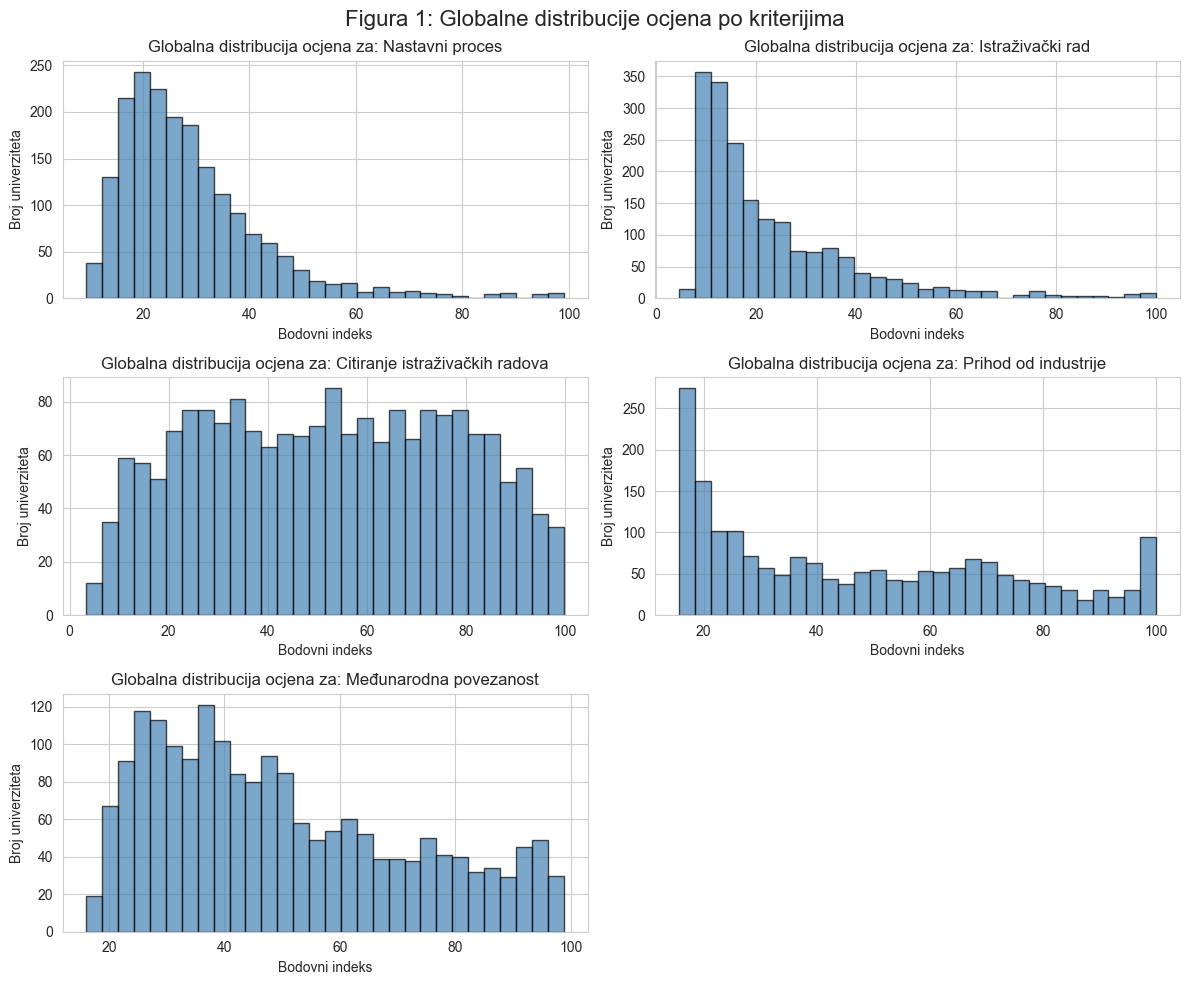

In [38]:
###@title **Figura 1: Globalne distribucije ocjena po kriterijima** { display-mode: "form" }
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(major_scores):
    data = df[col][df[col] > 0]
    axes[i].hist(data, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    match i:
        case 0:
            title = f"Nastavni proces"
        case 1:
            title = f"Istraživački rad"
        case 2:
            title = f"Citiranje istraživačkih radova"
        case 3:
            title = f"Prihod od industrije"
        case 4:
            title = f"Međunarodna povezanost"


    axes[i].set_title("Globalna distribucija ocjena za: "+title)
    axes[i].set_xlabel('Bodovni indeks')
    axes[i].set_ylabel('Broj univerziteta')

if len(major_scores) < len(axes):
    fig.delaxes(axes[-1])

fig.suptitle("Figura 1: Globalne distribucije ocjena po kriterijima", fontsize=16)
plt.tight_layout()
plt.show()

Sada, imamo puno bolji uvid u realno stanje te možemo vidjeti distribucije koje jako podsjećaju na neke poznate oblike.  
Recimo, distribucija za istraživački rad jako podsjeća na gamma distribuciju, dok nastavni proces i u neku ruku i međunarodna povezanost podsjećaju na lognormalnu distribuciju.  
Dotaknuti ćemo se dodatne analize nešto kasnije.

**Pogledajmo sada stanje po kontinentima.**


### 1.1 **Deskriptivna analiza univerziteta po kontinentima**
---

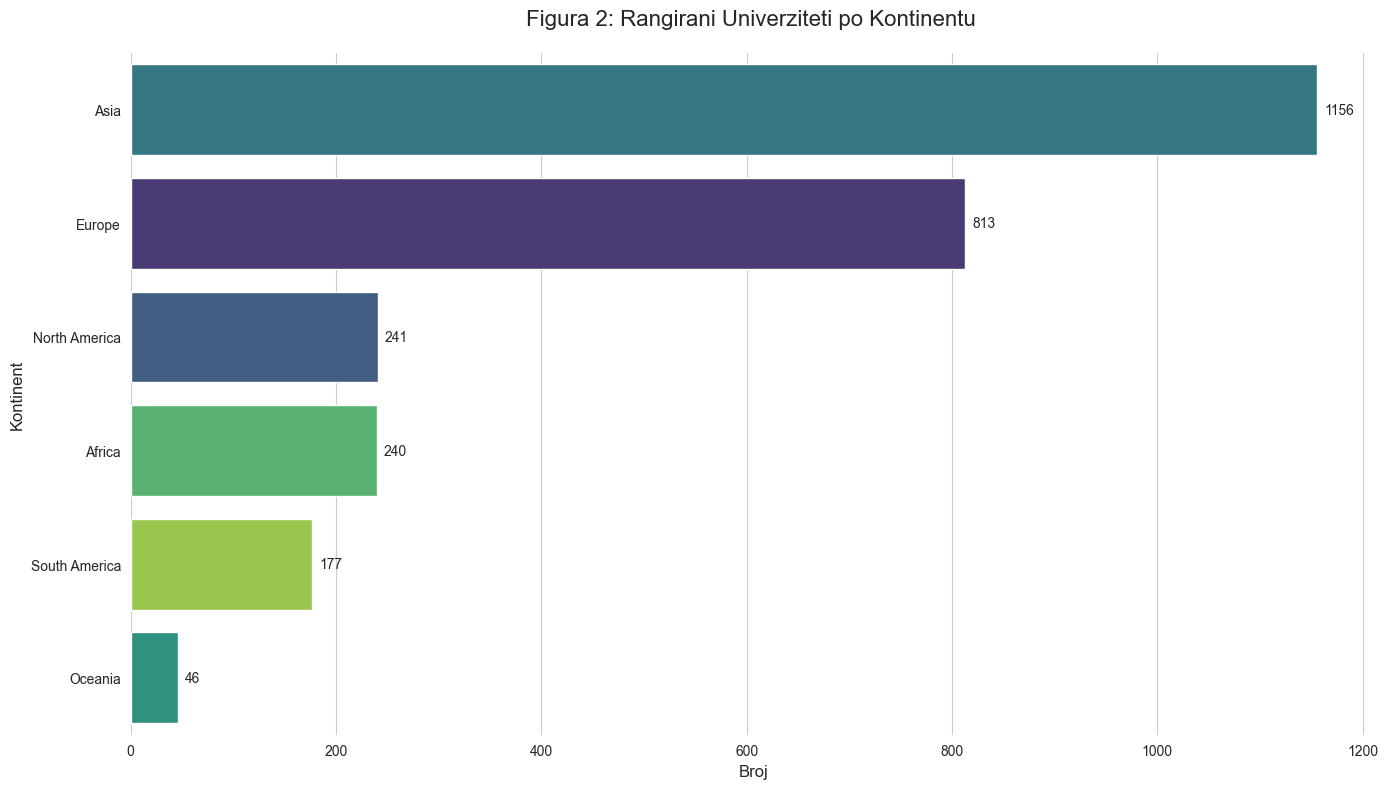

In [28]:
def get_continent(country_name):
    country_mapping = {
        'USA': 'United States',
        'US': 'United States',
        'UK': 'United Kingdom',
        'UAE': 'United Arab Emirates',
        'Hong Kong': 'China',
        'Macau': 'China',
        'Republic of Ireland': 'Ireland',
        'Russian Federation': 'Russia',
        'Taiwan': 'China',
        'Palestine, State of': 'Palestine',
        'Kosovo': 'Serbia'
    }
    
    standardized_name = country_mapping.get(country_name, country_name)
    
    try:
        country_code = pc.country_name_to_country_alpha2(standardized_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        try:
            for suffix in [' of', ' the', ' and']:
                if suffix in standardized_name:
                    standardized_name = standardized_name.split(suffix)[0]
                    break
            country_code = pc.country_name_to_country_alpha2(standardized_name)
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            return pc.convert_continent_code_to_continent_name(continent_code)
        except:
            print(f"Could not map country: {country_name}")
            return 'Unknown'

continent_data = df['location'].apply(get_continent)

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")
ax = sns.countplot(y=continent_data, 
                  order=continent_data.value_counts().index,
                  hue=continent_data,  
                  palette="viridis",
                  legend=False)

for p in ax.patches:
    ax.annotate(f"{int(p.get_width()):}", 
               (p.get_width(), p.get_y() + p.get_height()/2),
               ha='left', va='center', 
               xytext=(5, 0), 
               textcoords='offset points',
               fontsize=10)

plt.title("Figura 2: Rangirani Univerziteti po Kontinentu ", fontsize=16, pad=20)
plt.xlabel("Broj", fontsize=12)
plt.ylabel("Kontinent", fontsize=12)
sns.despine(left=True, bottom=True)
plt.tight_layout()

unmapped = df[continent_data == 'Unknown']['location'].unique()
if len(unmapped) > 0:
    print("\nUnmapped countries found:")
    for country in unmapped:
        print(f"- {country}")
plt.show()

***Napomena**: Prije nego što prođemo kroz ovaj histogram, vrijedi spomenuti da je inicijalno došlo do sitnih problema sa pokretanjem ovog koda.*
*Naime, bibliotečka funkcija korištena za mapiranje država u odgovarajuće kontinente podržava samo one države i teritorije koje imaju službeni ISO 3166, kod kojeg Kosovo i dalje nema (Mada neslužbeno, kod XK koriste mnoge druge međunarodne organizacije).*

*Za naše potrebe, to ne pravi problem, jer u ovom dijelu ne poredimo pojedine države, pa je bilo dovoljno instance kod kojih je polje `location` imalo vrijednost Kosovo "dodijeliti" nekoj drugoj Evropskoj državi (Logičan izbor je Srbija).*  

**Zaključak posmatranja:**  
Vidljivo je da je rang lista **ubjedljivo sačinjena od univerziteta iz Azije**, popraćeni Evropom koja također ima respektabilan broj. Nakon toga slijede Sjeverna Amerika i Afrika sa minimalnom razlikom u broju, što je dobar pokazatelj kolika je razlika u napretku obrazovnog sistema na ovim kontinentima poredeći broj država.

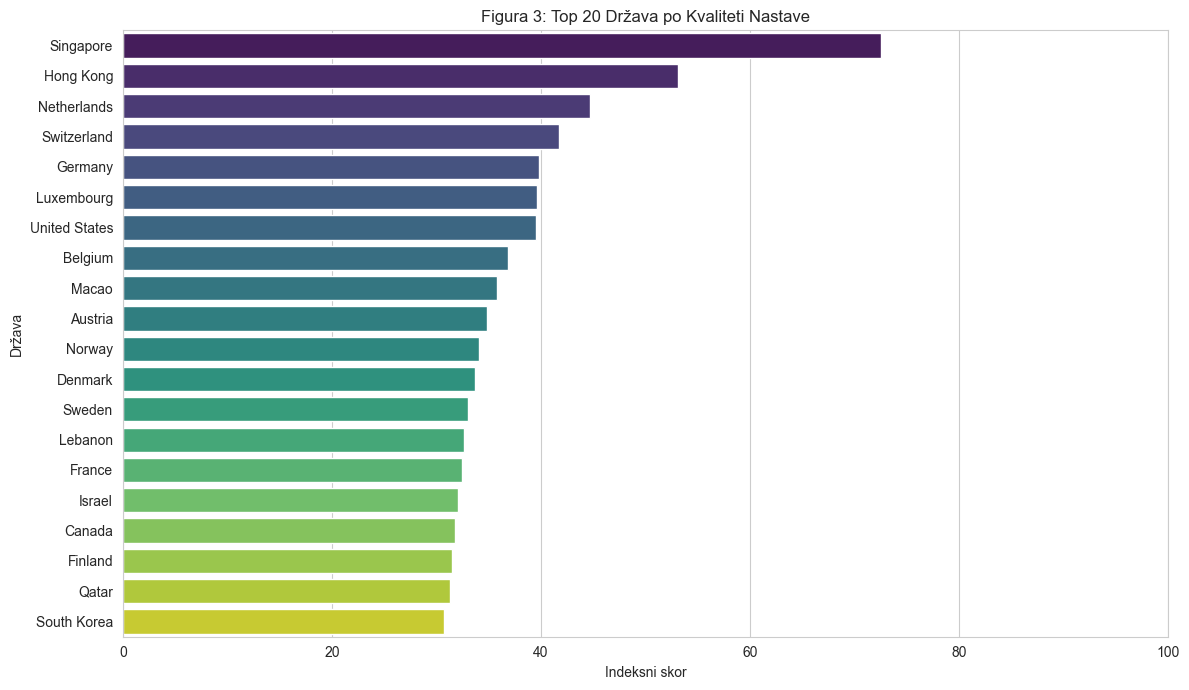

In [32]:
# Izračunaj medijan teaching score po državama (samo rangirani)
df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()
top_20_countries = (
    df_ranked.groupby('location')['scores_teaching']
    .median()
    .sort_values(ascending=False)
    .head(20)
    .reset_index()
)

plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_20_countries,
    y='location',
    x='scores_teaching',
    palette='viridis',
    orient='h',
    hue='location',    # dodano da se ukloni upozorenje
    legend=False       # i da se ne prikazuje legenda
)
plt.title('Figura 3: Top 20 Država po Kvaliteti Nastave')
plt.xlabel('Indeksni skor')
plt.ylabel('Država')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


**Zaključak posmatranja:**  
Iznad se nalazi prikaz **država sa najkvalitetnijim nastavnim procesom na univerzitetima.**  
Jasno je da je **Singapur** daleko ispred ostatka svijeta, dok **Hong Kong** pokušava da parira na drugom mjestu, vidljiv je veliki jaz između njih. 

Zanimljivo je da **država poput Kine se ne nalazi u top 20 po ovom kriteriju**, dok vidimo dvije teritorije koje su prema samom Kineskom ustavu njen dio: Hong Kong, koji je ruku na srce diskutabilan, i Makau. Posmatrajmo dublje ovu zanimljivost.

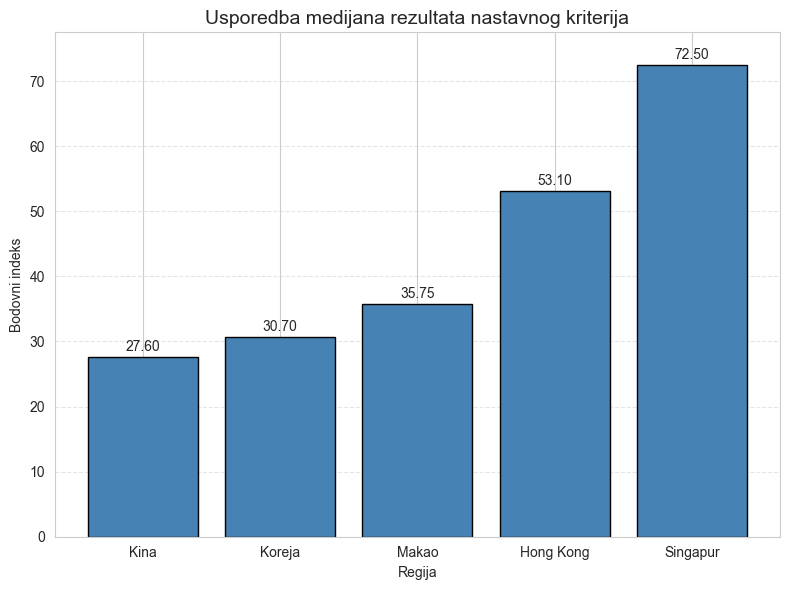

In [39]:
median_scores = {
    'Kina': df_ranked[df_ranked['location'] == 'China']['scores_teaching'].median(),
    'Koreja': df_ranked[df_ranked['location'] == 'South Korea']['scores_teaching'].median(),
    'Makao': df_ranked[df_ranked['location'] == 'Macao']['scores_teaching'].median(),
    'Hong Kong': df_ranked[df_ranked['location'] == 'Hong Kong']['scores_teaching'].median(),
    'Singapur': df_ranked[df_ranked['location'] == 'Singapore']['scores_teaching'].median()
}

# 2. Create bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(median_scores.keys(), median_scores.values(), color='steelblue', edgecolor='black')

# 3. Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# 4. Labels and styling
plt.title("Usporedba medijana rezultata nastavnog kriterija", fontsize=14)
plt.ylabel("Bodovni indeks")
plt.xlabel("Regija")
plt.ylim(0, max(median_scores.values()) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Kina je po ovom kriteriju medijalno za tri poena iza top 20. rangirane Sjeverne Koreje,** a ubjedljivo iza prvorangiranog Singapura, međutim ako pogledamo njene najbolje univerzitete, vidjet ćemo nešto zanimljivo.

In [59]:
from IPython.display import display, Markdown

def prikazi_top10_markdown_tablica(df, lokacija_eng):
    mapa_lokacija = {
        'China': 'Kina',
        'Singapore': 'Singapur',
        'Macao': 'Makao',
        'Hong Kong': 'Hong Kong'
    }
    
    df_top10 = df[df['location'] == lokacija_eng].copy()
    df_top10 = df_top10.sort_values('scores_overall_rank').head(10)
    
    markdown_text = f"### Top 10 univerziteta u {mapa_lokacija[lokacija_eng]}\n\n"
    markdown_text += "| Rang | Univerzitet |\n"
    markdown_text += "|------|-------------|\n"
    for row in df_top10.itertuples():
        rank = int(row.scores_overall_rank / 10)  # dijelimo sa 10
        name = row.name
        markdown_text += f"| **{rank}** | {name} |\n"
    markdown_text += "\n"
    
    display(Markdown(markdown_text))

for grad in ['China', 'Singapore', 'Macao', 'Hong Kong']:
    prikazi_top10_markdown_tablica(df_ranked, grad)


### Top 10 univerziteta u Kina

| Rang | Univerzitet |
|------|-------------|
| **12** | Tsinghua University |
| **14** | Peking University |
| **43** | Shanghai Jiao Tong University |
| **44** | Fudan University |
| **56** | Zhejiang University |
| **57** | University of Science and Technology of China |
| **73** | Nanjing University |
| **151** | Sichuan University |
| **158** | Huazhong University of Science and Technology |
| **165** | Wuhan University |



### Top 10 univerziteta u Singapur

| Rang | Univerzitet |
|------|-------------|
| **19** | National University of Singapore |
| **32** | Nanyang Technological University, Singapore |



### Top 10 univerziteta u Makao

| Rang | Univerzitet |
|------|-------------|
| **194** | University of Macau |
| **275** | Macau University of Science and Technology |



### Top 10 univerziteta u Hong Kong

| Rang | Univerzitet |
|------|-------------|
| **35** | University of Hong Kong |
| **53** | Chinese University of Hong Kong |
| **65** | The Hong Kong University of Science and Technology |
| **82** | City University of Hong Kong |
| **88** | Hong Kong Polytechnic University |
| **319** | Hong Kong Baptist University |



**Kina ima 10 univerziteta u top 200**, što pokazuje široku zastupljenost, dok Singapur ima samo 2 univerziteta, ali oba su unutar top 35, što govori o njihovoj izuzetnoj kvaliteti. Hong Kong se ističe sa 5 univerziteta u top 100.

Makao, iako s dva univerziteta koji tek ulaze u top 200, ima bolju medijanu kvaliteta nastave od Kine. Ovo pokazuje da veličina i broj institucija nisu uvijek najbolji pokazatelj kvaliteta.

Iz ovog zaključujemo da **manje sredine poput Singapura i Makaa mogu imati koncentriraniji kvalitet**, dok **veće zemlje s više univerziteta mogu imati širi raspon kvaliteta**, što utiče na prosječne pokazatelje. Kvalitet stoga treba sagledavati dublje, a ne samo kroz kvantitet ili medijane.


**Balkanski poluotok** se također prominentno pojavljuje na ovoj rang-listi, te ćemo i njega posebno posmatrati:

In [69]:
balkanske_drzave = {
    'Albanija': 'ALB',
    'Bosna i Hercegovina': 'BIH',
    'Bugarska': 'BGR',
    'Hrvatska': 'HRV',
    'Grčka': 'GRC',
    'Crna Gora': 'MNE',
    'Sjeverna Makedonija': 'MKD',
    'Rumunija': 'ROU',
    'Srbija': 'SRB',  
    'Slovenija': 'SVN',
    'Turska': 'TUR'  
}

balkanski_podaci = df_ranked[df_ranked['location'].isin([
    'Albania', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia',
    'Greece', 'Montenegro', 'North Macedonia',
    'Romania', 'Serbia', 'Slovenia', 'Kosovo', 'Turkey'
])].copy()

balkanski_podaci['location'] = balkanski_podaci['location'].replace({
    'Kosovo': 'Serbia',
})

broj_univerziteta = balkanski_podaci['location'].value_counts().reset_index()
broj_univerziteta.columns = ['Država', 'Broj univerziteta']

prevod = {
    'Serbia': 'Srbija',
    'Montenegro': 'Crna Gora',
    'North Macedonia': 'Sjeverna Makedonija',
    'Albania': 'Albanija',
    'Bosnia and Herzegovina': 'Bosna i Hercegovina',
    'Bulgaria': 'Bugarska',
    'Croatia': 'Hrvatska',
    'Greece': 'Grčka',
    'Romania': 'Rumunija',
    'Slovenia': 'Slovenija',
    'Turkey': 'Turska'  
}

broj_univerziteta['Država'] = broj_univerziteta['Država'].map(prevod)

broj_univerziteta['ISO_kod'] = broj_univerziteta['Država'].map(balkanske_drzave)


figura = px.choropleth(
    broj_univerziteta,
    locations='ISO_kod',
    color='Broj univerziteta',
    scope='europe',
    color_continuous_scale='OrRd',
    title='<b>Balkanski poluotok: Rangirani univerziteti</b>',
    labels={'Broj univerziteta': 'Broj univerziteta'},
    hover_name='Država',
    hover_data={'ISO_kod': False}
)

figura.update_geos(
    visible=False,
    resolution=50,
    scope='world',
    center=dict(lon=22, lat=42),
    lataxis_range=[37, 47],     
    lonaxis_range=[14, 32]      
)



figura.update_layout(
    margin={"r":0,"t":40,"l":0,"b":0},
    width=900,
    height=600,
    coloraxis_colorbar=dict(
        title="Broj univerziteta",
        thickness=15,
        len=0.75
    )
)

pio.renderers.default = 'colab'  

figura.show()


Vidimo jedan zanimljiv interaktivni rangiranih visokoobrazovnih institucija sa Balkanskog poluostvra, gdje je vidljivo da **Turska dominira sa čak 75 univerziteta**, dok recimo **Albanija nema niti jednog.**  
Iako mapa prikazuje Kosovo kao nezavisnu teritoriju, zbog političke korektnosti i stava države Bosne i Hercegovine o njegovom statusu, odabrali smo da te univerzitete ne navodimo kao odvojenu cjelinu (Naravno, nije ovo jedini problem bio pri analizi i kodu, drugi je već ranije spomenut)

**Sada pogledajmo koje studijske oblasti nude najviše opcija studentima na globalnom nivou, odnosno, koji su fakulteti ili smjerovi najzastupljeniji među univerzitetima na listi.**

In [71]:
import pandas as pd
import plotly.express as px

df_ranked = df[df['scores_overall_rank'] < 1_000_000].copy()

subjects_series = df_ranked['subjects_offered'].dropna()

all_subjects = []
for subj_list in subjects_series:
    subjects = [s.strip() for s in subj_list.split(',')]
    all_subjects.extend(subjects)

from collections import Counter
subject_counts = Counter(all_subjects)

subject_freq = pd.DataFrame(subject_counts.items(), columns=['Subject', 'Count'])
subject_freq = subject_freq.sort_values(by='Count', ascending=False)

fig = px.bar(
    subject_freq.head(20), 
    x='Subject',
    y='Count',
    title='Najčešće ponuđeni smjerovi na univerzitetima',
    labels={'Count': 'Broj univerziteta', 'Subject': 'Predmet'},
    text='Count'
)
fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_tickangle=45,
    height=600
)
fig.show()

Najveći broj univerziteta na listi nudi studije iz oblasti _Computer Science_ (Računarstva) i _Business & Management_ (Biznisa i menadžmenta).

**Posmatrajmo sada kako izgleda međunarodna povezanost na najprestižnijim univerzitetima na svijetu.**

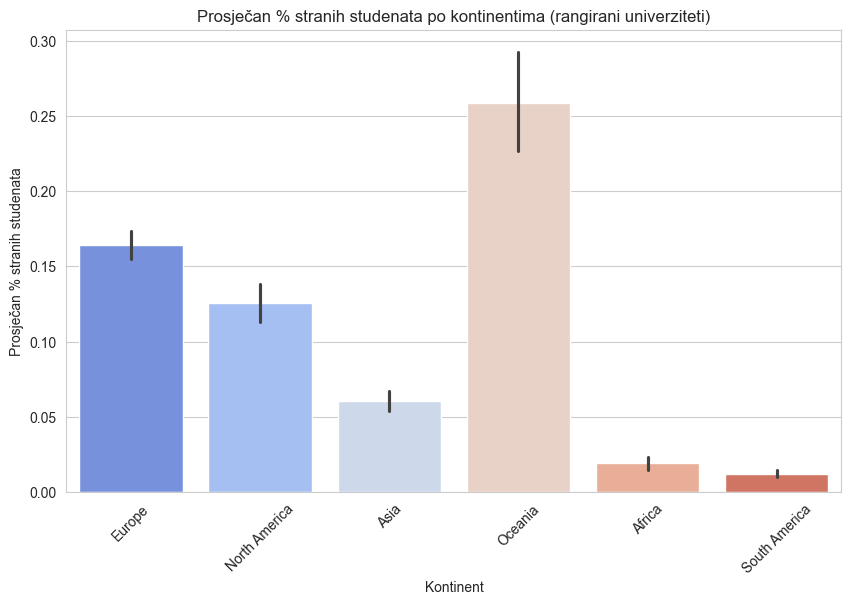

In [75]:


df_ranked['Continent'] = df['location'].apply(get_continent)

plt.figure(figsize=(10,6))
sns.barplot(
    data=df_ranked,
    x='Continent',
    y='stats_pc_intl_students',
    estimator=lambda x: x.mean(),
    palette='coolwarm',
    hue='Continent',    
    legend=False        
)
plt.title('Prosječan % stranih studenata po kontinentima (rangirani univerziteti)')
plt.ylabel('Prosječan % stranih studenata')
plt.xlabel('Kontinent')
plt.xticks(rotation=45)
plt.show()

**Zaključak posmatranja:** 
Konačno, imamo jednu statistiku ukorist Okeanije, postotak stranih studenata, sa nešto više od 25%.  
Možemo pretpostaviti da je glavni razlog manji broj stanovnika na ovom kontinentu u poređenju sa ostalima.  
Dalje, slijede Evropa (~16%) i Sjeverna Amerika(~13%). Azija ima tek oko 6% stranih studenata, ali tu možemo pretpostaviti da je razlog suprotan onome za Okeaniju.  
Afrika i Južna Amerika su na samom dnu liste sa oko 2% i 1% stranih studenata respektivno.

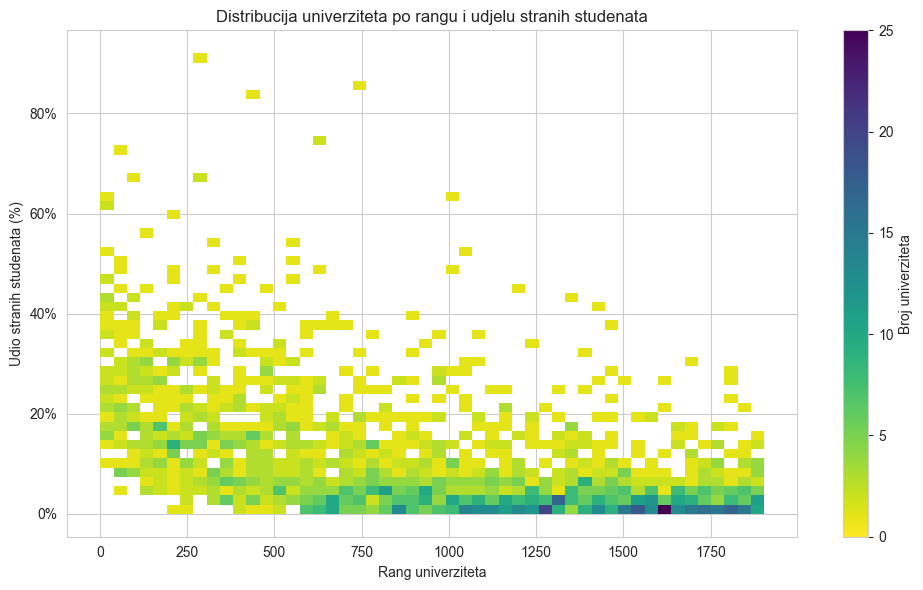

In [ ]:
import matplotlib.ticker as mtick

df_valid = df[df['scores_overall_rank'].astype(float) < 1_000_000].copy()

df_valid['stats_pc_intl_students'] = pd.to_numeric(df_valid['stats_pc_intl_students'], errors='coerce')
df_valid['scores_overall_rank'] = pd.to_numeric(df_valid['scores_overall_rank'], errors='coerce')

df_valid = df_valid.dropna(subset=['stats_pc_intl_students', 'scores_overall_rank'])

df_valid['scaled_rank'] = df_valid['scores_overall_rank'] / 10

if df_valid['stats_pc_intl_students'].max() <= 1.0:
    df_valid['stats_pc_intl_students'] *= 100

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_valid,
    x='scaled_rank',
    y='stats_pc_intl_students',
    bins=50,
    cmap='viridis_r',       
    cbar=True,
    cbar_kws={'label': 'Broj univerziteta'},
    vmin=0,                
    vmax=None              
)

plt.title('Distribucija univerziteta po rangu i udjelu stranih studenata')
plt.xlabel('Rang univerziteta')
plt.ylabel('Udio stranih studenata (%)')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
plt.tight_layout()
plt.show()

**Zaključak posmatranja:**
Ovaj heatmap poredi postotak stranih studenata na nekom univerzitetu i njegov rang na listi.  
Primjetno je da oni najbolji unverziteti imaju velik broj stranih studenata. To je razumljivo jer najbolji učenici žele na najbolje fakultete, a to nerijetko znači odlazak u drugu državu radi obrazovanja.  
Isto tako i univerziteti žele najbolje studente, tako da se često prave i dodatna mjesta isključivo za strane studente. 

Pogledajmo još jedan interesantan graf koji prikazuje koliko univerziteti dobivaju novca od privrednih subjekata, što kroz finansiranje istraživanja, što kroz ulaganje u buduće radnike, kao i nosioce same privrede u državi. 

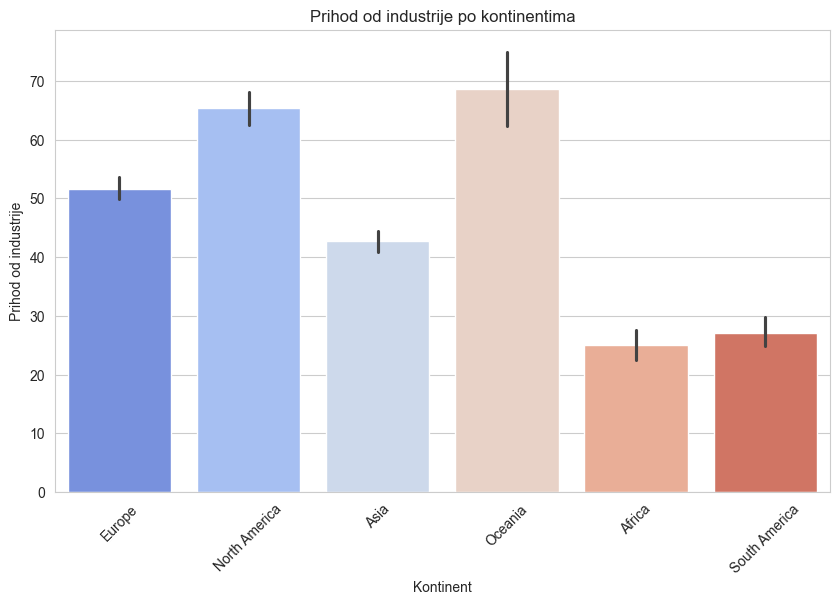

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=df_valid,
    x='Continent',
    y='scores_industry_income',
    estimator=lambda x: x.mean(),
    palette='coolwarm',
    hue='Continent',
    legend=False
)
plt.title('Prihod od industrije po kontinentima')
plt.ylabel('Prihod od industrije')
plt.xlabel('Kontinent')
plt.xticks(rotation=45)
plt.show()


Okeanija je ponovo na vrhu liste, te sada bilježe najbolje rezultate po ovom pitanju. Sjevernoamerički univerziteti ih prate u stopu i jasno je da privreda ulaže mnogo u svoju budućnost. Slijede Evropa i Azija, i na samom dnu liste vidimo Afriku i Južnu Ameriku. S obzirom na okolnosti možda je i očekivano da vidimo ove kontinente na dnu, ali se iskreno nadamo da će se u skorijoj budućnosti to stanje popraviti.

### <p>2. <a href="https://en.wikipedia.org/wiki/Probability_distribution_fitting" style="color:inherit">Prilagođavanje distribucija vjerovatnoće podataka</a> <br> _(eng. Probability distribution fitting)_</p>

Član tima: **Aid Mustafić**

---

### 3. Provjera prilagođenih distribucija - _[Chi-kvadratni goodness-of-fit test](https://www.geo.fu-berlin.de/en/v/soga-py/Basics-of-statistics/Hypothesis-Tests/Chi-Square-Tests/Chi-Square-Goodness-of-Fit-Test/index.html)_
Član tima: **Adnan Muradbegović**

---

### 4. Provjera statističkih normalnosti - _[Kolmogorov–Smirnov, Shapiro–Wilk i QQ-plot](https://en.wikipedia.org/wiki/Normality_test)_


Član tima: **Adnan Muradbegović**

---

### 5. Estimacija intervala pouzdanosti _(eng. confidence intervals)_


Član tima: **Zlatan Ljutika**

---

### 6. Estimacija pouzdanosti proporcije _(eng. proportion confidence intervals)_


Član tima: **Tarik Redžić**

---

## **Statistička inferencija seta podataka**

Da bi na osnovu do sada posmatranog seta podataka uspjeli istaknuti konkretne i korisne zaključke, u ovom poglavlju ćemo primjeniti metodu statističkog inferenciranja, testiranje statističkih hipoteza (eng. statistical hypothesis testing).

...

**Hipoteza 2.1.:** Balkanske članice Evropske Unije prosječno imaju bolje rezultate za istraživačko citiranje u odnosu na Balkanske zemlje koje nisu članice. (Predstavlja: Adnan Muradbegović)<br>
**Hipoteza H1:** Univerziteti sa manje studenata po nastavnom osoblju imaju prosječno bolje rezultate za nastavu. (Predstavlja: Zlatan Ljutika)<br>
**Hipoteza H2:** Državni univerziteti imaju prosječno bolje rezultate za nastavu od privatnih. (Predstavlja: Aid Mustafić)<br>
**Hipoteza H3:** Međunarodna povezanost Univerziteta u Sarajevu je značajno ispod evropskog prosjeka (Predstavlja: Tarik Redžić)<br>

### 2.1. **Hipoteza:** Balkanske članice Evropske Unije prosječno imaju veći broj bodova za istraživačko citiranje u odnosu na Balkanske zemlje koje nisu članice.

Član tima: **Adnan Muradbegović**

---

### 2.2. **Hipoteza:** Univerziteti sa manje studenata po nastavnom osoblju imaju više bodova za nastavu.
Član tima: **Ljut**

---

### 2.3. **Hipoteza:** Državni univerziteti imaju prosječno bolje rezultate za nastavu od privatnih.

Član tima: **Aid Mustafić**

---

U neposustajućoj debati između državnih i privatnih univerziteta često se provlači predrasuda da, **uprkos većim ulaganjima u privatne institucije, državni univerziteti,** zahvaljujući svojoj reputaciji i tradiciji, **imaju kvalitetniji nastavni kadar** i obrazuju stručnije diplomante.

<p>Hipoteze za ovu tvrdnju su:</p> <h5><b><i>Null</i> hipoteza [H0]:</b> Državni i privatni univerziteti imaju isti prosječni rezultat za nastavni proces.<br> <b>Alternativna hipoteza [H1]:</b> Državni univerziteti imaju prosječno bolje rezultate za nastavni proces od privatnih.</h5> 

---

Sada posmatrajmo uzorak: _Koliko je univerziteta na rang-listi zapravo privatnih, a koliko državnih?_

In [81]:
df_ranked[df_ranked['record_type'] == 'master_account'] = 'public' # Greška u datasetu, provjereno vrijedi.

df_ranked[df_ranked['location']=='United States']['record_type'].value_counts()

record_type
public     104
private     58
Name: count, dtype: int64

### 2.4. **Hipoteza:** Međunarodna povezanost Univerziteta u Sarajevu je značajno ispod evropskog prosjeka 

Član tima: **Tarik Redžić**

---

## **Linearni regresivni model seta podataka**

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Ut a volutpat nulla. Donec eu ante eget nisl posuere scelerisque. Nulla sed eros purus. In placerat diam vel augue aliquet, sit amet faucibus sem sagittis. Interdum et malesuada fames ac ante ipsum primis in faucibus. Vestibulum id diam magna. Curabitur porta urna ante, et aliquet odio blandit at. Cras viverra tellus id pulvinar rhoncus. Praesent id ullamcorper dolor. Nulla lacinia arcu a massa sollicitudin ullamcorper.

predvidjeti overall_score?

# Dobri linkovi


[1]https://www.timeshighereducation.com/world-university-rankings/world-university-rankings-2024-china-creeps-closer-top-10  
[Desno pored ranga ima sekcija "Academic insights", može mnogo poslužiti]https://www.timeshighereducation.com/world-university-rankings/2024/world-ranking 
[3]https://www.timeshighereducation.com/sites/default/files/the_2024_world_university_rankings_methodology.pdf
